In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [0]:
df=pd.read_excel('/content/drive/My Drive/Projects/Airlines Data.xlsx',parse_dates=True,index_col='Month')

In [0]:
print('Start Date :',df.index.min())
print('End Date :',df.index.max())

Start Date : 1995-01-01 00:00:00
End Date : 2002-12-01 00:00:00


 we have 7 year Airlines data from 1995 to 2002

In [0]:
# check for null values
df.isnull().sum()

Passengers    0
dtype: int64

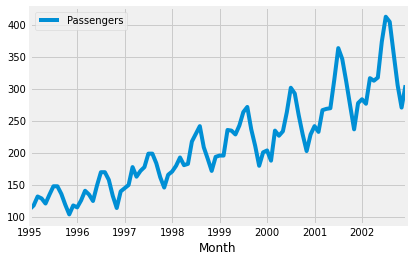

In [0]:
#let's look at how a data is varying per month
df.plot()



we can see that data is having an upward positive trend including seasonality too.
it clearly says that most of the passengers are traveling at the end of a year due to festival (Christmas etc.)

I am going for arima model and for that we have to check stationarity of the data and it seems like the data is non stationary but understading by visulization would be better.

There are lot of methods to check but most people use dickey fuller test which clearly gives an idea.

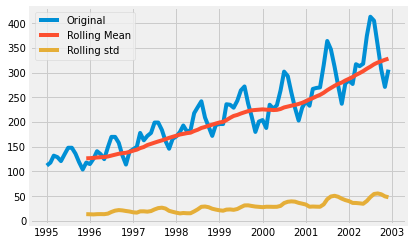

Test statistic                  1.340248
p-value                         0.996825
lags used                      12.000000
Number of observations used    83.000000
Critical value (1%)            -3.511712
Critical value (5%)            -2.897048
Critical value (10%)           -2.585713
dtype: float64


In [0]:
# we will define a function for checking stationarity
def stationarity_test(timeseries):

  roll_mean=pd.Series(timeseries).rolling(window=12).mean()
  roll_std=pd.Series(timeseries).rolling(window=12).std()
  plt.plot(timeseries,label='Original')
  plt.plot(roll_mean,label='Rolling Mean')
  plt.plot(roll_std,label='Rolling std')
  plt.legend()
  plt.show()
  # lets go for fuller test
  df_test=adfuller(timeseries)
  output=pd.Series(df_test[:4],index=['Test statistic','p-value','lags used','Number of observations used'])
    
  for key,value in df_test[4].items():

    output['Critical value (%s)'%key]=value
  print(output)
    
stationarity_test(df['Passengers'])

p-value is not less than 0.05  and test statastic also higher than  critical values by this analysis we can say this data is not stationary

In [0]:
#we have to go for log transformation to penalise larger values
df_log=np.log(df['Passengers'])


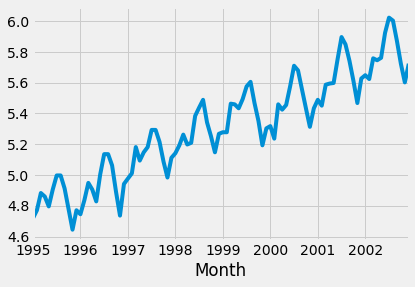

In [0]:
df_log.plot()

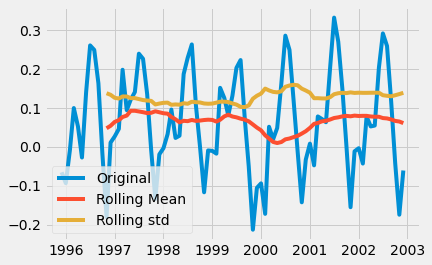

Test statistic                 -1.910930
p-value                         0.326937
lags used                      12.000000
Number of observations used    72.000000
Critical value (1%)            -3.524624
Critical value (5%)            -2.902607
Critical value (10%)           -2.588679
dtype: float64


In [0]:
rolling=df_log.rolling(window=12).mean()
df_log_minus_mean=df_log-rolling
df_log_minus_mean.dropna(inplace=True)
stationarity_test(df_log_minus_mean)


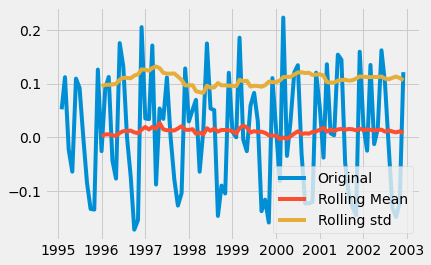

Test statistic                 -2.670823
p-value                         0.079225
lags used                      12.000000
Number of observations used    82.000000
Critical value (1%)            -3.512738
Critical value (5%)            -2.897490
Critical value (10%)           -2.585949
dtype: float64


In [0]:

df_log_diff=df_log-df_log.shift()
df_log_diff.dropna(inplace=True)
stationarity_test(df_log_diff)

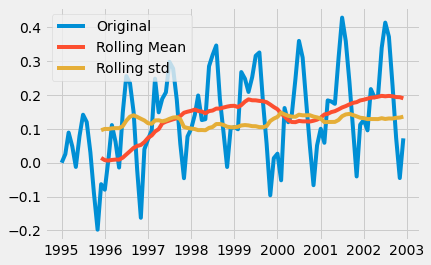

Test statistic                 -2.835036
p-value                         0.053441
lags used                      12.000000
Number of observations used    83.000000
Critical value (1%)            -3.511712
Critical value (5%)            -2.897048
Critical value (10%)           -2.585713
dtype: float64


In [0]:
#exponential weight average method
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
stationarity_test(df_log_exp_decay)

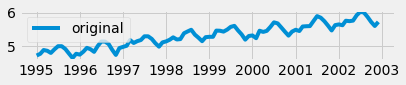

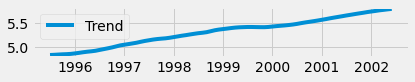

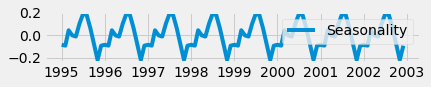

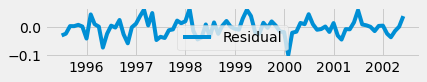

<Figure size 432x288 with 0 Axes>

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decomposition=seasonal_decompose(df_log)
trend=seasonal_decomposition.trend
seasonality=seasonal_decomposition.seasonal
residual=seasonal_decomposition.resid


plt.subplot(411)
plt.plot(df_log,label='original')
plt.legend()
plt.show()
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend()
plt.show()
plt.subplot(413)
plt.plot(seasonality,label='Seasonality')
plt.legend()
plt.show()
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.show()
plt.tight_layout()

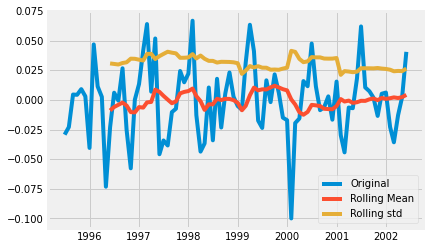

Test statistic                -5.907863e+00
p-value                        2.681970e-07
lags used                      3.000000e+00
Number of observations used    8.000000e+01
Critical value (1%)           -3.514869e+00
Critical value (5%)           -2.898409e+00
Critical value (10%)          -2.586439e+00
dtype: float64


In [0]:
stationarity_test(residual.dropna())

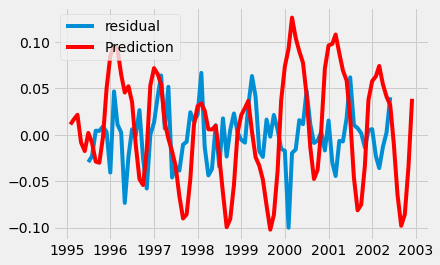

In [0]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(residual,label='residual')
plt.plot(results.fittedvalues, color='red',label='Prediction')
plt.legend()


Text(0.5, 1.0, 'RMSE:137.53')

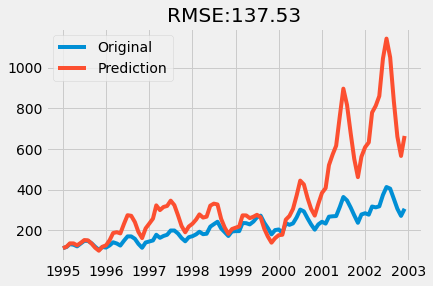

In [0]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df,label='Original')
plt.plot(predictions_ARIMA,label='Prediction')
plt.legend()
plt.title('RMSE:%.2f'%(np.sqrt(sum(predictions_ARIMA-df['Passengers'])**2)/len(df['Passengers'])))

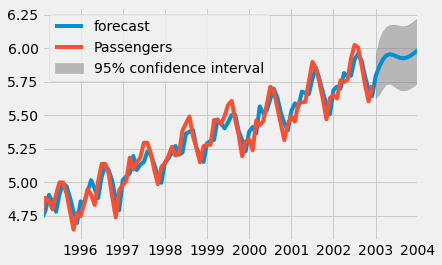

In [0]:
results.plot_predict(1,108)
plt.show()

In [0]:
df_log

Month
1995-01-01    4.718499
1995-02-01    4.770685
1995-03-01    4.882802
1995-04-01    4.859812
1995-05-01    4.795791
                ...   
2002-08-01    6.003887
2002-09-01    5.872118
2002-10-01    5.723585
2002-11-01    5.602119
2002-12-01    5.723585
Name: Passengers, Length: 96, dtype: float64

In [0]:
train=df[:'2001']
test=df['2002']

In [0]:
df=pd.read_excel('/content/drive/My Drive/Projects/Airlines Data.xlsx')

In [0]:
train_size=int(len(df)*0.8)
train_data,test_data=df[:train_size],df[train_size:]

In [0]:
X_train,y_train=train_data.iloc[:,0:1],train_data.iloc[:,-1]
X_test,y_test=test_data.iloc[:,0:1],test_data.iloc[:,-1]

In [0]:
import datetime
X_test['Month'] = pd.to_datetime(X_test['Month'])
X_test['Month']=X_test['Month'].map(datetime.datetime.toordinal)

In [0]:
from sklearn.linear_model import LinearRegression
reg=LinearRegression()
reg.fit(X_train,y_train)
y_pred=reg.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
rmse

793.5982535727501

In [0]:
train_data.iloc[:,0:1].shape

(76, 1)

In [0]:
from sklearn.ensemble import RandomForestRegressor
reg=RandomForestRegressor(n_estimators=1000,max_depth=1,min_samples_split=5,min_samples_leaf=1)
reg.fit(X_train,y_train)
y_pred=reg.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
rmse

175.42073041631258

we haven't got any powerfull model yet so we will go for LSTM

Epoch 1/100
 - 1s - loss: 0.0520
Epoch 2/100
 - 0s - loss: 0.0223
Epoch 3/100
 - 0s - loss: 0.0152
Epoch 4/100
 - 0s - loss: 0.0166
Epoch 5/100
 - 0s - loss: 0.0152
Epoch 6/100
 - 0s - loss: 0.0144
Epoch 7/100
 - 0s - loss: 0.0108
Epoch 8/100
 - 0s - loss: 0.0076
Epoch 9/100
 - 0s - loss: 0.0087
Epoch 10/100
 - 0s - loss: 0.0073
Epoch 11/100
 - 0s - loss: 0.0048
Epoch 12/100
 - 0s - loss: 0.0058
Epoch 13/100
 - 0s - loss: 0.0048
Epoch 14/100
 - 0s - loss: 0.0041
Epoch 15/100
 - 0s - loss: 0.0051
Epoch 16/100
 - 0s - loss: 0.0072
Epoch 17/100
 - 0s - loss: 0.0055
Epoch 18/100
 - 0s - loss: 0.0058
Epoch 19/100
 - 0s - loss: 0.0047
Epoch 20/100
 - 0s - loss: 0.0053
Epoch 21/100
 - 0s - loss: 0.0052
Epoch 22/100
 - 0s - loss: 0.0059
Epoch 23/100
 - 0s - loss: 0.0055
Epoch 24/100
 - 0s - loss: 0.0048
Epoch 25/100
 - 0s - loss: 0.0041
Epoch 26/100
 - 0s - loss: 0.0056
Epoch 27/100
 - 0s - loss: 0.0044
Epoch 28/100
 - 0s - loss: 0.0055
Epoch 29/100
 - 0s - loss: 0.0060
Epoch 30/100
 - 0s - lo

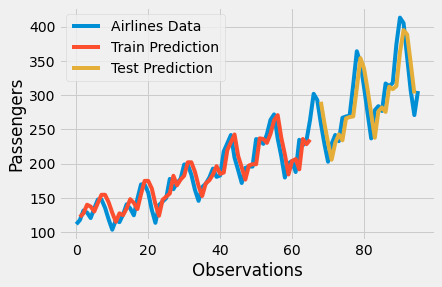

In [0]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Bidirectional,Dropout,LSTM,Dense
#define function for cross validation of time series
def create_dataset(dataset, lookback=1):
    dataX = []
    dataY = []
    for i in range(len(dataset) - lookback - 1):
        a = dataset[i: (i+lookback), 0]
        dataX.append(a)
        dataY.append(dataset[i+lookback,0])
    return np.array(dataX), np.array(dataY)


data = "/content/drive/My Drive/Projects/Airlines Data.xlsx"

np.random.seed(7)

df = pd.read_excel(data, usecols=[1])
df = df.dropna()
dataset = df.values
dataset = dataset.astype("float32")
#scaling
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

train_dataset = dataset[:int(len(dataset)*0.7), :]
test_dataset = dataset[int(len(dataset)*0.7):, :]

lookback = 1
trainX, trainY = create_dataset(train_dataset, lookback)
testX, testY = create_dataset(test_dataset, lookback)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#LSTM model
model = Sequential()
model.add(LSTM(20,return_sequences=True, input_shape=(1, lookback)))
model.add(Dropout(0.2))
model.add(LSTM(20))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(trainPredict)+lookback, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lookback*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label="Airlines Data")
plt.plot(trainPredictPlot, label="Train Prediction")
plt.plot(testPredictPlot, label="Test Prediction")
plt.xlabel("Observations")
plt.ylabel("Passengers")
plt.legend()
plt.show()



We got best model than previous but we can minimize this error by adding more amount of data.